# Critical Road Infrastructure

This notebook identifies and analyzes the most critical parts of the transport network. It pinpoints nodes with the highest betweenness centrality and then maps their distribution across provinces and towns.

## 0 Setup environment

In [1]:
import os
import warnings

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import pandas as pd

warnings.filterwarnings("ignore")

In [2]:
BASE_PATH = "data"
BOUNDARIES_FILE = os.path.join(BASE_PATH, "boundaries.gpkg")
TRANSPORT_NETWORK_FILE = os.path.join(BASE_PATH, "merged_network_weighted.graphml")
CENTRALITY_FILE = os.path.join(BASE_PATH, "centrality_measures.csv")

## 1 Load baseline data

In [3]:
df_centrality = pd.read_csv(CENTRALITY_FILE).set_index("osmid")
df_centrality.head()

,degree,closeness,betweenness
osmid,,,
300744370,0.000053,0.003119,0.003929
300744933,0.000053,0.003071,0.002748
300744970,0.000053,0.003209,0.000208
300745522,0.000053,0.003549,0.003817
300746507,0.000053,0.003476,0.003332


In [4]:
graph_transport = ox.load_graphml(TRANSPORT_NETWORK_FILE)
gdf_nodes = ox.graph_to_gdfs(graph_transport, edges=False)
gdf_nodes = gdf_nodes[["geometry"]]
gdf_nodes.head()

,geometry
osmid,
300744370,POINT (124.03376 11.76261)
300744933,POINT (124.06395 11.76468)
300744970,POINT (124.05778 11.86383)
300745522,POINT (123.90828 11.91029)
300746507,POINT (123.99164 11.96455)


In [5]:
gdf_nodes = gdf_nodes.join(df_centrality)
print(f"Loaded {len(gdf_nodes)} nodes with centrality measures.")
gdf_nodes.head()

Loaded 56932 nodes with centrality measures.


,geometry,degree,closeness,betweenness
osmid,,,,
300744370,POINT (124.03376 11.76261),0.000053,0.003119,0.003929
300744933,POINT (124.06395 11.76468),0.000053,0.003071,0.002748
300744970,POINT (124.05778 11.86383),0.000053,0.003209,0.000208
300745522,POINT (123.90828 11.91029),0.000053,0.003549,0.003817
300746507,POINT (123.99164 11.96455),0.000053,0.003476,0.003332


In [6]:
CRITICALITY_PERCENTILE = 0.95  # Define "critical" as the top 5% of nodes based on betweenness centrality

betweenness_threshold = gdf_nodes["betweenness"].quantile(CRITICALITY_PERCENTILE)
gdf_critical_nodes = gdf_nodes[gdf_nodes["betweenness"] >= betweenness_threshold]

f"Identified {len(gdf_critical_nodes)} critical nodes (top {100-CRITICALITY_PERCENTILE*100:.0f}%) with betweenness >= {betweenness_threshold:.6f}"

'Identified 2847 critical nodes (top 5%) with betweenness >= 0.014295'

In [7]:
gdf_boundaries = gpd.read_file(BOUNDARIES_FILE)
_, gdf_edges = ox.graph_to_gdfs(graph_transport)

## 2 Identify critical nodes

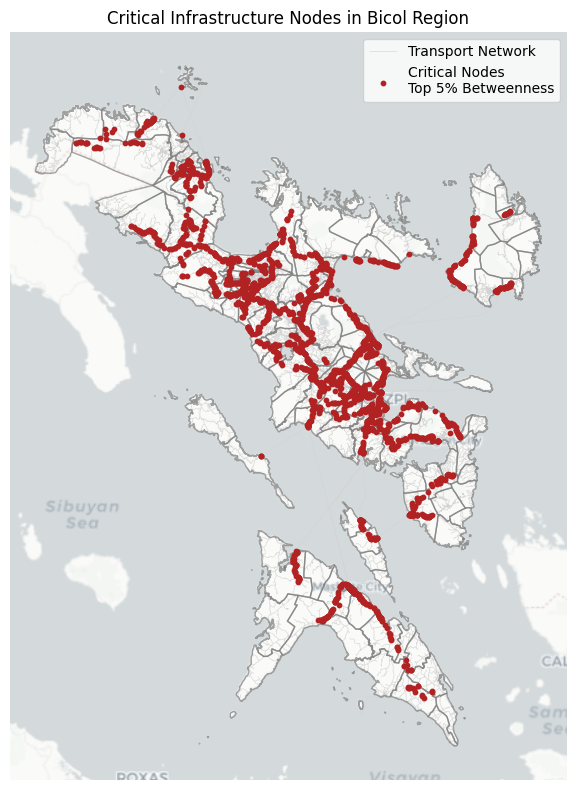

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

gdf_boundaries.plot(
    ax=ax,
    edgecolor="gray",
    facecolor="none",
    linewidth=1.0,
    alpha=0.7,
    zorder=2,
    label="Town Boundaries",
)
gdf_edges.plot(
    ax=ax,
    linewidth=0.5,
    edgecolor="#d3d3d3",
    alpha=0.8,
    zorder=1,
    label="Transport Network",
)

gdf_critical_nodes.plot(
    ax=ax,
    marker="o",
    color="firebrick",
    markersize=10,
    zorder=3,
    label=f"Critical Nodes\nTop {100-CRITICALITY_PERCENTILE*100:.0f}% Betweenness",
)

cx.add_basemap(ax, crs=gdf_boundaries.crs, source=cx.providers.CartoDB.Positron, attribution="")

ax.set_title("Critical Infrastructure Nodes in Bicol Region")
ax.set_axis_off()
ax.legend(loc="upper right", prop={"size": 10})
plt.tight_layout()

filepath = os.path.join(BASE_PATH, "critical_infrastructure_map.png")
plt.savefig(filepath, dpi=300, bbox_inches="tight")

plt.show()

## 3 Analyze distribution of critical nodes

In [9]:
gdf_critical_nodes_located = gpd.sjoin(gdf_critical_nodes, gdf_boundaries, how="inner", predicate="within")
gdf_critical_nodes_located.head()

,geometry,degree,closeness,betweenness,index_right,town,province
osmid,,,,,,,
300750509,POINT (123.96609 11.94667),0.000053,0.003525,0.017540,82,Cataingan,Masbate
352385867,POINT (123.893 11.94182),0.000070,0.003612,0.022548,94,Placer,Masbate
1783355398,POINT (123.93129 11.91621),0.000053,0.003549,0.017973,94,Placer,Masbate
1783355566,POINT (123.92514 11.92446),0.000053,0.003562,0.017986,94,Placer,Masbate
1783355816,POINT (123.92134 11.93063),0.000053,0.003574,0.018054,94,Placer,Masbate


In [10]:
df_province_counts = gdf_critical_nodes_located["province"].value_counts().reset_index()
df_province_counts.columns = ["province", "critical_node_count"]

filepath = os.path.join(BASE_PATH, "critical_nodes_by_province.csv")
df_province_counts.to_csv(filepath, index=False)

print("--- Critical Nodes per Province ---")
print(df_province_counts)

--- Critical Nodes per Province ---
          province  critical_node_count
0    Camarines Sur                  993
1            Albay                  819
2          Masbate                  305
3         Sorsogon                  268
4  Camarines Norte                  207
5      Catanduanes                  169


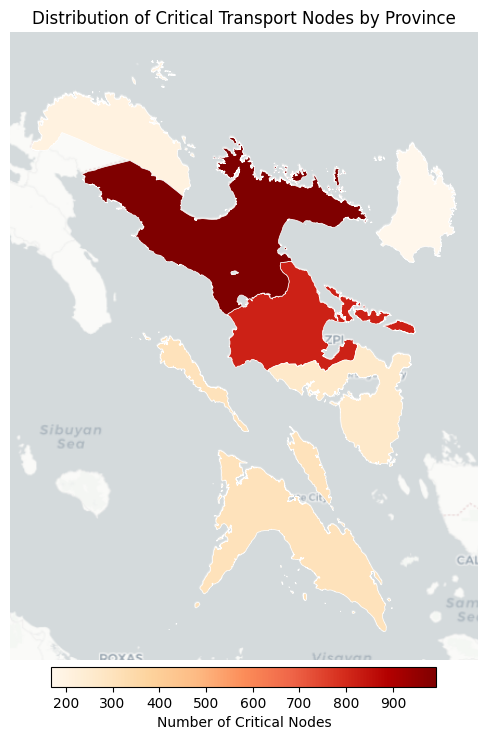

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

gdf_provinces = gdf_boundaries.dissolve(by="province", aggfunc="sum")
gdf_provinces = gdf_provinces.merge(df_province_counts, on="province")

gdf_provinces.plot(
    column="critical_node_count",
    ax=ax,
    legend=True,
    legend_kwds={
        "label": "Number of Critical Nodes",
        "orientation": "horizontal",
        "pad": 0.01,
        "shrink": 0.5,
    },
    cmap="OrRd",
    edgecolor="white",
    linewidth=0.5,
)

cx.add_basemap(
    ax,
    crs=gdf_provinces.crs,
    source=cx.providers.CartoDB.Positron,
    attribution="",
)

ax.set_title("Distribution of Critical Transport Nodes by Province")
ax.set_axis_off()
plt.tight_layout()

filepath = os.path.join(BASE_PATH, "critical_nodes_choropleth_province.png")
plt.savefig(filepath, dpi=300, bbox_inches="tight")

plt.show()

In [12]:
df_town_counts = gdf_critical_nodes_located["town"].value_counts().reset_index()
df_town_counts.columns = ["town", "critical_node_count"]

filepath = os.path.join(BASE_PATH, "critical_nodes_by_town.csv")
df_town_counts.to_csv(filepath, index=False)

print("\n--- Top 15 Towns with Most Critical Nodes ---")
print(df_town_counts.head(15))


--- Top 15 Towns with Most Critical Nodes ---
             town  critical_node_count
0    Legazpi City                  120
1    Masbate City                  110
2     Tabaco City                  100
3          Daraga                   90
4   Sorsogon City                   87
5      Guinobatan                   81
6      Iriga City                   79
7           Bulan                   77
8         Camalig                   77
9      Ligao City                   72
10      Minalabac                   72
11     San Andres                   70
12          Basud                   70
13      Calabanga                   66
14       Tinambac                   57


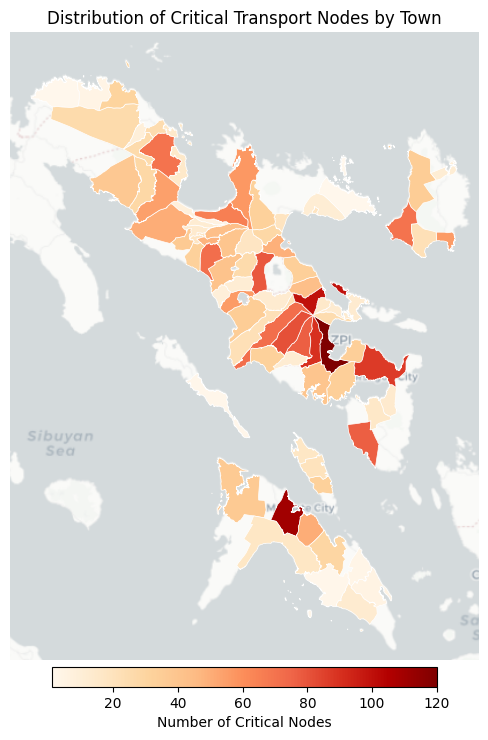

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

gdf_towns_counts = gdf_boundaries.merge(df_town_counts, on="town")

gdf_towns_counts.plot(
    column="critical_node_count",
    ax=ax,
    legend=True,
    legend_kwds={
        "label": "Number of Critical Nodes",
        "orientation": "horizontal",
        "pad": 0.01,
        "shrink": 0.5,
    },
    cmap="OrRd",
    edgecolor="white",
    linewidth=0.5,
)

cx.add_basemap(
    ax,
    crs=gdf_towns_counts.crs,
    source=cx.providers.CartoDB.Positron,
    attribution="",
)

ax.set_title("Distribution of Critical Transport Nodes by Town")
ax.set_axis_off()
plt.tight_layout()

filepath = os.path.join(BASE_PATH, "critical_nodes_choropleth_town.png")
plt.savefig(filepath, dpi=300, bbox_inches="tight")

plt.show()